# Forecasting Future Revenue for Your Movie
## Analysis and Prediction of Movies
## BUDT 758X MovieTeller 


# Introduction

<p>With the rapid development of technology and big data, entertainment is quite a big part of people's daily life. Thus, more and more people and investors focus on movie industry in the context of promoting the development of movie industry. Exploring the influence factors of box office and trying to predict box office level could make a difference when it comes to promoting the development of movie industry and helping investors to make better decisions to gain high revenues. </p>

<p>As we all know, as time goes by,the key factors that affect the box office are increasing and their underlying relationships are ever-changing. All these challenges make it more valuable for us to try to analyze the trend of people's interests and the market and build models to predict revenues for future movies to help the people in the film industry. </p>

<p>Our project will include more analysis than processing. The goal is to utilize analysis to help people who are either investors or have interests in movies to make better decisions on selecting the movies to invest or get a glance at a movie’s future by predicting a movie’s revenue class.</p>

Below are our project flowchart and description.


<img style="float: left;" src="https://i.loli.net/2020/05/01/M9n2g1VvjBmhY6p.png" width=450 height=200> 

# Data Processing
## 1) Import all libraries

In [1]:
!pip install plotly==4.6.0
!pip install wordcloud
!pip install wordnet


#General Import
import pandas as pd
import numpy as np
import sklearn
import re
import datetime as dt
import ast as ast
import math
import sys
import random
random.seed(12345)

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')
sns.set_palette('tab20')
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

#Text Analysis
import string
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('stopwords')
from wordcloud import WordCloud

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

[nltk_data] Downloading package wordnet to /Users/shiyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shiyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Data processing, metrics and modeling
import requests
from pprint import PrettyPrinter
pp = PrettyPrinter()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Logistic Regression
from sklearn.feature_selection import RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

#kNN Model
from sklearn.neighbors import KNeighborsClassifier

#SVM Model
from sklearn.metrics import classification_report
from sklearn.svm import  SVC

#Tree Model
from sklearn.tree import DecisionTreeClassifier

#Bagging Model
from sklearn.ensemble import BaggingClassifier

#Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Boosting Model
from sklearn.ensemble import AdaBoostClassifier

#Voting Model
from sklearn.ensemble import VotingClassifier

#Final Test
from joblib import dump,load
from IPython.display import clear_output

## 2) Data aquisition

IMDB and TMDB provide a public dataset that includes all the movies information such as genre, budget and gross. We merge the 'IMDB' table and the 'TMDB' table. There are 5000 records focusing on the movie market mainly in the United States.
  
The IMDB dataset link: https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset  
The TMDB dataset link: https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv

In [3]:
#These codes do not need to run every time
imdb_movies = pd.read_csv('imdb_5000.csv', header=0, na_values=['NaN', '[]'])
imdb_movies.columns # check the cleaned column title in imdb dataset

tmdb_movies = pd.read_csv('tmdb_5000_movies.csv', header = 0,na_values=['NaN', '[]'])

movies = pd.merge(imdb_movies,tmdb_movies,left_on="title",right_on="original_title")

movies.drop_duplicates('original_title',inplace = True) #drop duplicates

#Write csv to file
#movie.to_csv('movies.csv',index = False)

## 3) Data Cleaning for predictive model

When merging the data set we should consider  problems:
* multi-value attributes
* duplication 
   * duplicated columns
   * duplicated rows
* missing data
* target selection

Here are the rules and logic that we fill Na, transform and manipulate our dataset

**Production_companies**:For `production_companies`,we will select the first column as the movie's main production company. Also, we added a new column `num_production_companies` to represent the total number of production companies of a certain movie. There are a large number of missing values so that we choose to set NA in `main_production_company` to Unknown, a new category of this feature and set NA in `num_production_companies` to 1, because at least there should be one production company.

**Production_countries**:`production_countries` is also a string-represented list of dictionary.But considering that we have already had a feature column `country`, we only add a new column `num_production_countries` representing the total number of countries that collaberates in the production of a certain movie.

**Release_date**:For `release_date`, we would only keep the month of it in that we have already had a column of year of the movie and also we assume that movies that are released in different month have different probability to be successful. 

**spoken_languages**:Since we have a duplicated column `language` that has less missing values, we determined to explode `spoken_language` to get the total number of languages `num_spoken_languages` in which a certain movie has been translated. 

**status**:As we see the summary of status, it has no missing value and has three categoris. Therefore, we use dummy variables  `status_post_production`, `status_released` and `status_rumored` to make this column more suitable for prediction model.

**Tagline**:Same as `overview` and `keywords`, we will use these text values in text analysis later but will not include them in prediction model. Therefore, here we assign 0,1 to indicate whether the movie has a tagline or not. 

**vote_count and vote_average**:As we can see below, `vote_count` and `vote_average` have many zero values and the variance of `vote_count` is quite large. we did not regards zero as missing value. Instead, we think zero represent the unpopularity of a movie. However, we still need to standarlize `vote_count` to scale data to fall within a specified range.

**Genres_x**:`genres_x` describes the categories of the movies such as Action for Action movie, Family for movies telling stories of family and Thriller for Horror movie. Therefore `genres_x` can be used as categorical data for both inference an prediction later on. In order to prepare the `genres_x` data for later analysis. We also create a new column `num_genre` since we assume that more genres might increase the probability of success.
 
**Color**:`color` describes if the movie is a color movie or a black and white movie. For the accuracy of our value, real values searched from the Internet are filled in.

**Actor facebook likes & actor name**:We first took `actor_1_name` and `actor_1_facebook_likes` and check null values.However, it turns out that these are all documentary films with no major actors. Therefore when processing missing data like this, we filled 'No Actor' for the actor's name and 0 for the actor's facebook likes.The same method is applied when dealing with
`actor_2_name`,`actor_2_facebook_likes`,`actor_2_name`,`actor_3_facebook_likes`.

**Num_critic_for_reviews**:`num_critic_for_reviews` describes how many critics review the movie. The null values only takes 0.73% of the whole data set. so we fill the mean to the missing value

**Duration**:`duration` describes the length of movie which is stored in minutes such as 178 minutes for 'Avatar'. The null values are a tiny portion for `duration` so it can be filled in by searching on the Internet.

**Country**:In the country column, there is only one missing value. Since the movie called'Dawn Patrol' has no country feature, we fill in the missing actual country name 'USA'.

**Content_rating**:A content rating usually places a media source into one of a number of different categories, which tell what age group is suitable to view said media.There are 174 missing value, and we create a new category named 'unknown' to decrease the inconsistency of random filled value. 

**Aspect_ratio**:The aspect ratio of a geometric shape is the ratio of its sizes in different dimensions. The most two common ratio in this data set is '2.35' with number of 2149 instances and'1.85' with 1835 instances. Thus we use before fill method to fill these null value.

**facenumber_in_poster**:`facenumber_in_poster` describes the number of faces appeared in the poster of a movie. We could see the distribution of this variable is quite bias, so we decide to use mode to fill the missing values. 

**Num_user_for_reviews**:`num_user_for_reviews` describes the number of users that wrote the revies for the movies. Since the number of missing value in this column is not large and the ditribution is not bias, we use mean to fill the NAs.

**Gross**：`gross` describes the gross of the movie. Since it is one of the most important value that we need to predict and as a target variable, its missing value would affect the model a lot, we will use web scraping to fill in those values  in our next step.

**Cast_total_facebook_likes, num_voted_users**;For these two numberical features, we used min/max normalization to transform the scale to fall into a specified range.


**budget_x and budget_y**:The `budget` column stores the total cost to make this movie. It is an important feature for our movie dataset, we combined the data we get from both two dataset, and still find 231 missing value, which is quiet much for future prediction.Filling method for four cases:

    1.if budget of y is missing only, we set the budget as the budger of x;
    2.if budget of x is missing only, we set the budger as the budger of y;
    3.if neither of the budget is missing, after we check the data set, the two value is close to each other and in most cases they are the same, wo we decide to set the average of these two column as the final budget.
    4.if the budget of imdb and budget of y is both missing, we tried using API directly to fill in. But the effect was not satisfying because the original data is also absent. Considering small amount of missing value, we decided to drop them.

In [4]:
#Load Dataset
#movie=pd.read_csv("movies.csv",na_values=['NaN', '[]'])
movie=movies.copy().reset_index(drop=True)
#Replace NA values with a formatted list of dictionary
movie['production_companies'].replace(np.nan,'[{"name": "","id": ""}]',inplace=True)
#Unstack production_companies
companies=None
for i in range(len(movie)):
    record=movie["production_companies"][i]
    new=ast.literal_eval(record)
    data=pd.DataFrame(new)
    data=data.unstack().to_frame().T
    company=data['name']
    companies=pd.concat([companies,company])
#Create new columns "main_production_company" and "num_production_companies"
companies=companies.reset_index(drop=True)
movie['main_production_company']=companies.iloc[:,0]
movie['num_production_companies']=companies.apply(lambda x: x.count(), axis=1)
#label NA in main_production_company as Unknown
movie["main_production_company"]=movie["main_production_company"].fillna(value="unknown")
#label NA in num_production_company as 1
movie["num_production_companies"]=movie["num_production_companies"].fillna(value=1)
#Drop original column
movie.drop('production_companies',axis=1,inplace=True)
#Replace NA values with a formatted list of dictionary
movie['production_countries'].replace(np.nan,'[{"iso_3166_1": "","name": ""}]',inplace=True)

In [5]:
#Unstack 'production_countries'
countries=None
for i in range(len(movie)):
    record=movie["production_countries"][i]
    new=ast.literal_eval(record)
    data=pd.DataFrame(new)
    data=data.unstack().to_frame().T
    country=data['iso_3166_1']
    countries=pd.concat([countries,country])
#Create new columns "main_production_company" and "num_production_companies"
countries=countries.reset_index(drop=True)
movie['num_production_countries']=countries.apply(lambda x: x.count(), axis=1)
#label NA in num_production_company as 1
movie["num_production_countries"]=movie["num_production_countries"].fillna(value=1)
#Drop original column
movie.drop('production_countries',axis=1,inplace=True)

In [6]:
#transfer string into datetime and substract month into a new column
movie['release_date']=pd.to_datetime(movie['release_date'])
movie['month']=movie['release_date'].map(lambda x: x.month)
##Drop original column
movie.drop('release_date',axis=1,inplace=True)

In [7]:
#Replace NA values with a formatted list of dictionary
movie['spoken_languages'].replace(np.nan,'[{"iso_639_1": "","name": ""}]',inplace=True)

#Unstack 'spoken_languages'
languages=None
for i in range(len(movie)):
    record=movie["spoken_languages"][i]
    new=ast.literal_eval(record)
    data=pd.DataFrame(new)
    data=data.unstack().to_frame().T
    language=data['iso_639_1']
    languages=pd.concat([languages,language])
#Create new columns "main_production_company" and "num_production_companies"
languages=languages.reset_index(drop=True)
movie['num_spoken_languages']=languages.apply(lambda x: x.count(), axis=1)
#label NA in num_production_company as 1
movie["num_spoken_languages"]=movie["num_spoken_languages"].fillna(value=1)
#Drop original column
movie.drop('spoken_languages',axis=1,inplace=True)

In [8]:
#See the distribution of status
#movie.groupby(by='status')['title_x'].count()
#Create dummy variables
movie[['status_post_production','status_released','status_rumored']]=pd.get_dummies(movie.status)
#Drop original column
movie.drop('status',axis=1,inplace=True)

#Create tagline_or_not
movie['tagline_or_not']=movie.apply(lambda x: 1 if x.tagline!=None else 0, axis=1)
#Drop the original column
movie.drop('tagline',axis=1,inplace=True)

In [9]:
#Split genres_x
for i in range(0,8):
    new_df=pd.DataFrame({'genres'+str(i):movie['genres_x'].str.split('|').str[i]})
    movie=pd.concat([movie,new_df],axis=1)

# Create a new column num_genres
columns=['genres0','genres1','genres2','genres3','genres4','genres5','genres6','genres7']
movie['num_genres']=movie[columns].apply(lambda x: x.count(), axis=1)

#Keep the first genre as genre and rename genre0 as genre
movie.drop(['genres_x','genres1','genres2','genres3','genres4','genres5','genres6','genres7'],axis=1,inplace=True)
movie.rename(columns={"genres0":"genre"},inplace=True)

In [10]:
#extract the 'duration' attribute out to process indepently
durationDF=movie[['title_x','duration']]
movie.drop('duration',axis=1,inplace=True)
#transit dataframe to prepare for filling in missing values
transit=durationDF.T

#fill in null values with the actual data or mean value for duration
transit.fillna({1398:0,3398:durationDF['duration'].mean(),3785:153,3856:116,4028:143,4331:durationDF['duration'].mean()},inplace=True)
duration=transit.T
duration.drop('title_x',axis=1,inplace=True)

#reattach duartion attribute back to the movie dataframe which consists all of our data
#this command can only be run once or you will create duplicate columns
movie=pd.concat([movie,duration],axis=1)

In [11]:
#Variable: budegt_x or budget_y
movie.budget_x.describe()
c=(movie.budget_x==0).astype(int).sum()
g=movie["budget_x"].isna().sum()
#print(f'zero in budget_x: {c}')
#print(f'na in budget_x: {g}')
movie.budget_y.describe()
d=(movie.budget_y==0).astype(int).sum()
h=movie["budget_y"].isna().sum()
#print(f'zero in budget_y: {d}')
#print(f'na in budget_y: {h}')
# zero in budget_x: 0
# na in budget_x: 317
# zero in budget_y: 873
# na in budget_y: 0
# fill 0 for na in budget
movie['budget_x'].fillna(value = 0, inplace = True)
movie['budget_x'].isna().sum()
movie.loc[(movie['budget_x'] != 0) &(movie['budget_y'] == 0),'budget']= movie['budget_x']
movie.loc[(movie['budget_x'] == 0) &(movie['budget_y'] != 0),'budget']= movie['budget_y']
movie.loc[(movie['budget_x'] != 0) &(movie['budget_y'] != 0),'budget']= (movie['budget_y']+ movie['budget_x'])/2
# Delete the rest NAs
movie['budget'].isna().sum()
#Drop orignal columns
movie.drop(['budget_x','budget_y'],axis=1,inplace=True)

In [12]:
#fill in with mean value
meanNUFR=movie.num_user_for_reviews.mean()
movie.num_user_for_reviews.fillna(meanNUFR,inplace=True)

#fill Null values for Color 
movie.fillna({'color':'Color'},inplace=True)

#fill Null values for num_critic_for_reviews
movie.fillna({'num_critic_for_reviews':movie['num_critic_for_reviews'].mean()},inplace=True)

# fill unknown for na in content rating
movie['content_rating'].fillna(value = 'unknown', inplace = True)

#find the movie 'Dawn Patrol' with no country and fill in the country US 
movie[movie['country'].isna()]
movie['country'].fillna('USA',inplace = True)
movie[movie['title_x'] == 'Dawn Patrol']

# fill near value before for 'aspect_ratio'
movie['aspect_ratio'].fillna(method ='bfill', inplace = True)
# Transfer into factor
movie['aspect_ratio']=movie['aspect_ratio'].astype('category')

# fill Null values for facenumber_in_poster
movie.facenumber_in_poster.fillna(movie.facenumber_in_poster.mode(),inplace = True)

In [13]:
# Drop duplicated columns
movie.drop(["overview",'runtime','title_y', 'revenue','homepage',
            "movie_title","original_title","keywords","genres_y",'id','movie_imdb_link','language','cast_total_facebook_likes','plot_keywords'],axis=1,inplace=True)

#rename columns
movie.rename(columns={"title_x":"title",'title_year':'year','original_language':'language'},inplace=True)

#Drop NAs
movie.dropna(inplace=True)

##Save the cleaned data into csv
#movie.to_csv('movies_cleaned.csv',index = False)

## 4) Data Cleaning for NLP Analysis

In [14]:
#Extract columns for NLP and drop NAs
movie_extracted=movies[['release_date','overview','gross']]
text=movie_extracted.dropna()

#Keep only year for our data
text['release_year'] = text['release_date'].str.split('-').str[0]
text.sort_values(by = 'release_year', ascending = True,inplace = True)

##Save the cleaned text data into csv
#text.to_csv('movies_text.csv',index = False)


# Data Exploration  


In [15]:
#Load ‘cleaned dataset for prediction’
#data = pd.read_csv('movies_cleaned.csv')
data=movie.dropna().reset_index(drop=True)
#data.head()

### 1) Movie productions among years
In this dataset, the earliest movie is from 1925, the newest is from 2016. It is obvious that movies are produced more and more since 1980, and then went into a movie era.

### 2) Most profitable movie genre

In this dataset, we could find that Family movies have the highest average profit followed by Musical and Animation. These three kinds of movies are targets at all levels of audience. The stack bar chart demonstrates that the top 3 have a relatively low budget, so that's why these movies are most profitable. The top 2 costly movie genre is Action and Adventure.

### 3) Top-ranking business valuable directors

These directors are famous directors we have seen obviously, after we conduct quantitative analysis by ranking the total profit they made, we can discovere that Steven Spielberg is the most business valuable director followed by James Cameron and George Lucas.

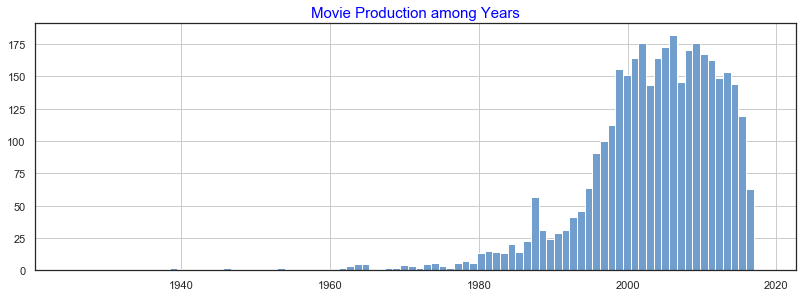

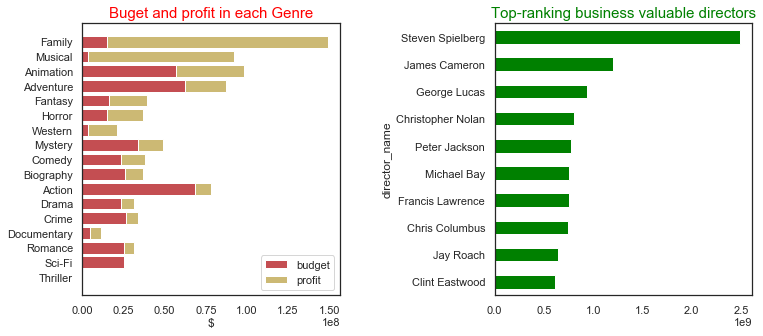

In [16]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
plt.title('Movie Production among Years',color='blue',fontsize =15)
data['year'].hist(range=(1925,2018),bins=90,color=(114/255,158/255,206/255))

#subplot 2
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
df1=data[["genre","budget","gross"]].copy()
df1["profit"]=df1.gross-df1.budget
df1=df1.dropna()
for_genre=df1.groupby(by="genre")["budget","gross","profit"].mean().sort_values(by='profit')
labels =  list(for_genre.index)
plt.barh(labels, for_genre.budget, fc = 'r', label='budget')
plt.barh(labels, for_genre.profit, left=for_genre.budget, fc = 'y', label='profit')
plt.title("Buget and profit in each Genre",color='red',fontsize =15)                                                    
plt.xlabel("$")                                                          
plt.legend(loc=4)                                                    

#subplot 3
plt.subplot(2,2,2)
plt.title('Top-ranking business valuable directors',color='green',fontsize =15)
df2=data[["title","director_name","budget","gross"]].copy()
df2["profit"]=df2.gross-df2.budget
df2=df2.dropna()
df2.groupby(by="director_name")["profit"].sum().sort_values(ascending = False).head(10).sort_values(ascending = True).plot(kind="barh",color="green")

plt.subplots_adjust(wspace = 0.6, hspace =0)
plt.show()

### 4) The Number And Average IMDB Scores of Different Genres

* The total average score is 6.5 and average scores for all types of movies are between 5.8 and 7.3, so we can make a conclusion that there is no sharp fluctuation of scores among different genre, but little difference is still a signal that different type renders different average scores. 
* The top 3 productive movies are Camera, Action and Drama. These movies are relaxing and funny, as well as are suitable for all target customers. Some of the low productive movies' is not having a low rate, which means minority genre may have a excellent plot and surprising ideas that make people like them. 
* Horror movies have the lowest average imdb score. But still horror movie has regular products, and is one of top ten profitable movie genres, therefore, movie's rate may be less related to gross.

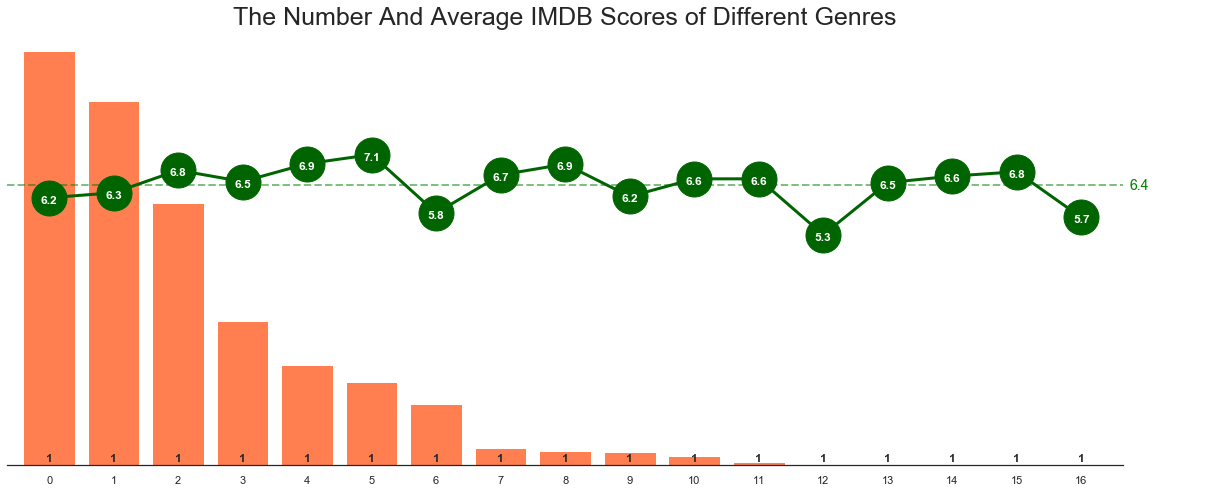

In [17]:
# create the dataset of genre
genre_data=data.groupby('genre')[['title', 'imdb_score']].agg({'title': 'count', 'imdb_score': 'mean'}).sort_values(by='title', ascending=False).reset_index()
#plot a bar chart
fig, ax =  plt.subplots(figsize=(20,8))
genre_data.title.plot(kind='bar',label='',width=0.8,color='coral',fontsize=11)
plt.title('The Number And Average IMDB Scores of Different Genres', fontsize=25)
#set the axis
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False, right=False, labelleft=False, color='white')

# label the amount
x= np.arange(genre_data['genre'].nunique())
y = genre_data['genre'].value_counts().values
for x,y in zip(x, y):
    ax.annotate(y, xy=(x,y+15), fontsize=12, weight='bold', ha='center', va='center')
#add another plot
ax1= ax.twinx()
ax1.axhline(genre_data['imdb_score'].mean(), color='green', linestyle='--', linewidth=2, alpha=0.5)
#set the axis
plt.plot(genre_data.imdb_score,color = 'darkgreen',marker='o', markersize=35, linewidth=3)
ax1.set_ylim(0, 10)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, left=False, right=False, labelright=False, labelbottom=False)

# label the score marker
num = np.arange(genre_data.genre.nunique())
values = genre_data['imdb_score'].values
for x,y in zip(num, values):
    ax1.annotate(round(y,1), xy=(x,y-0.05), color='white', fontsize=12, weight='bold', ha='center', va='center')

# label the avreage line
ax1.annotate('Average IMDB Score', xy=(17, data['imdb_score'].mean()-0.4), color='green', fontsize=12, ha='center', va='center')
ax1.text(17-0.1, data['imdb_score'].mean(), round(data['imdb_score'].mean(),1), color='green', fontsize=14, ha='center', va='center');

### 5) The relationship between count of people who rated and gross

This plot shows us that there seems a positive relationship between gross and the number of people who vote for the movies. But the point at low values has high density. Mobies are concentrated at low gross and low voting count.

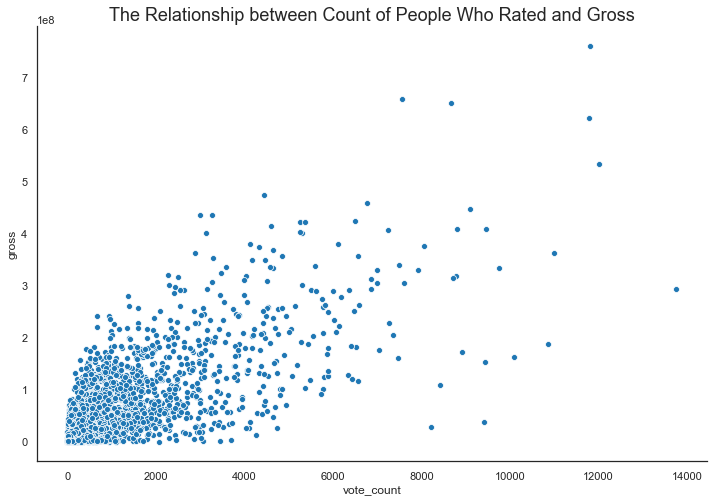

In [18]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=data, x='vote_count', y='gross')
plt.title('The Relationship between Count of People Who Rated and Gross', fontsize=18)
sns.despine()

# Text Analysis of movie overviews
  
After seperating 4 classes for gross level, we are interested about the key words of movie overviews in these levels. Whether there is a similarity or difference among these levels? This notebook contains steps of text processing including text preparation, term frequency and wordclouds for each gross level.

## 1) Classify Gross
As our target variable, it is widely spread across its gross range. This will introduce too much noise into our model. And also this project is focused on classification which is to classify the movie's investment return performance into different performance class according to their gross like classifying rich people as millionaires, billionaires and Forbes Rich List, etc. Classifying movies' gross can also help understand the movie's investment return performance by looking at a relative clear class instead of a long number.<br>
After exploring the distribution of the movie's gross data, we first scale the number down to scientific notation. And cut the bins according to the data's quantile.<br>

In [19]:
#Classify target varibles
text['gross']=text['gross']/100000000
def classify(column):
    if (column>=0)&(column<=0.10):
            return(1)
    elif (column>0.10)&(column<=0.31):
            return(2)
    elif (column>0.31)&(column<=0.69):
            return(3)
    else:
            return(4)

text['gross_c']=text['gross'].apply(classify)
text.drop(['gross'],axis=1,inplace=True)

In [20]:
gross_class = list(text.gross_c.unique())
#text.gross_c.value_counts()
#3    849
#4    846
#2    786
#1    760

## 2) Word Clouds
### 2.1) stop words Defining
Instead of normal stopwords, there are many words related to movies and writing styles of a movie's overview.

In [21]:
# Remove meaningless words
a = ['one','two','three','four','five','six','seven','nd','st','rd','th']
b = ['it','in','ve','ha','wa','come','well','way','could','would','really','also','even','alway','always','still','never','must','back']
# meaningless verbs
c = ['said','asked','did','go','want','try','meet','across','named','got','do','make','know','watch','see','becomes','get','set','begin','first']
# nouns that appear so frequently that makes the comparison of two word clouds meaningless
d = ['movie','type','story','show','perform','film','discover','team']
e= ['woman','man','girl','son','daughter','brother','wife','old','life','father','mother','world','family','friend','soon','year','young','man','new','time','must','help','set','find','finds','three','day','group','become','take','back','seem','keep','turn']
add_stopwords = a+b+c+d+e
stop_words = set(stopwords.words('english'))

for i in range(len(add_stopwords)):
    stop_words.add(add_stopwords[i])

### 2.2) Text preprocessing
we gathered the overviews of movies of each gross class and apply text analysis to the main theme of these movies, steps of text processing:
        
* Tokenization — convert sentences to lower case words.
* Removing unnecessary punctuation, tags, numbers
* Removing stop words — frequent words such as ”the”, ”is”, etc. that do not have specific semantic.
* Stemming — words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.
* Lemmatization — Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

In [22]:
#store the text reviews for each gorss class
list_overviews = []
temp_class_reviews = ''
lemmatizer=WordNetLemmatizer()
for gross in gross_class:
# iterate through the gross_class
    for view in text['overview'][text['gross_c'] == gross]: 
        view = view.lower()#convert to lowercase
        view = re.sub(r'\d+', '', view) # remove arabian numbers
        view = view.translate(str.maketrans(dict.fromkeys(string.punctuation)))  # remove puctuations
        view = " ".join([lemmatizer.lemmatize(word) for word in view.split()]) # Lemmatize
        view = [word for word in view.split() if word not in stop_words] 
        view = ' '.join(view)+' '  # remove stop words
        temp_class_reviews += view
    list_overviews += [temp_class_reviews]
    temp_class_reviews = ''

### 2.3) Plot the words cloud
Class one contains more topic about love, relationship, secret, school and city ect., which indicates a family and school life topic movie; Class Two contains topics about earth, save, mission, home, which indicates a theme focused more on human and natrue or war and spy topic; Class Three contains topics about save, child, and former, which imply that on this level of movie, the theme is more focused on a theme with children; the class with highest gross includes together, town, decide, child, return. It's less insightful compared to other topics.

please input a number from 1-4: 1


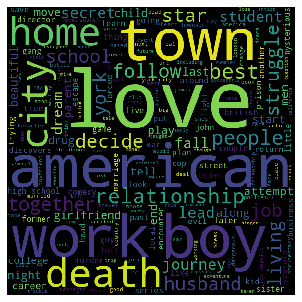

In [23]:
#Draw words cloud
gross_level = int(input('please input a number from 1-4: '))

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='black',
                stopwords = stop_words, 
                min_font_size = 10).generate(list_overviews[gross_level-1]) 

# plot the WordCloud image                        
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show();

# According to the clouds, we can pick up top four words of interests in each gross class

    Class1: town/american/death/love
    Class2: earth/save/mission/home
    Class3: secret/former/save/child
    Class4: home/child/town/murder

## 3) WOI Analysis (word of interests)
Based on words in wordclouds, we extracted the top 4 words in each gross class to represent their most frequent topic. For example, in Class 1, words are town, american, death and love, by which we can have a bold guess that movies in Class 1 are more dramatic, like soap opera. However, even if it also has 'town' words, movie themes in Class 4 with higher gross are more about murder, a movie subject more likely to catch the audience away.

Next, we are going to calculate the frequency of these words according to certain gross of each year.
### 3.1) Texting processing for frequency of woi analysis

In [24]:
# to lower
text['overview'] =text['overview'].apply(lambda x: x.lower())
# remove arabian numbers
text['overview']=text['overview'].apply(lambda x: re.sub(r'\d+', '', x))
# remove punctuation
text['overview']=text['overview'].apply(lambda x: x.translate(str.maketrans(dict.fromkeys(string.punctuation))))
#Lemmatize
lemmatizer = WordNetLemmatizer() 
text['overview'] = text['overview'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
# remove stopwords
text['overview'] = text['overview'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# Create count_of_words column
text['count_of_words']=text['overview'].apply(lambda x: len(x.split()))

### 3.2) Calculate occurence of woi under different gross class over years

In [25]:
#Extract used columns
sub_text=text[['overview','gross_c','release_year','count_of_words']]

#Define words of interests based on results of our word clouds above
target = pd.DataFrame({1:['town','american','death','love'],
         2:['earth','save','mission','home'],
         3:['secret','former','save','child'],
         4:['home','child','twon','murder']})

#Calculate count of target words
count_of_target=[]
for i in range(len(sub_text)):
    row=sub_text.iloc[i,:]
    num=row['gross_c']
    count=0
    for j in range(0,4):
        tar=target[num][j]
        count_i=row['overview'].count(tar)
        count+=count_i
    count_of_target.append(count)

count_of_target=pd.Series(count_of_target)

#Concat tables
sub_text_1=pd.concat([sub_text,count_of_target],axis=1)
#Change column name
sub_text_1.rename({0: 'count_of_target_words'}, axis=1, inplace=True)

#Grouped by gross class and release year
grouped=sub_text_1.groupby(by=['gross_c','release_year']).sum()
grouped['frequency_woi']=grouped['count_of_target_words']/grouped['count_of_words']
grouped=grouped.reset_index()

#Convert time to numeric value
grouped['release_year']=grouped['release_year'].apply(lambda x: int(x))

### 3.3) Plot the results using plotly
Before 1980, due to economical and social environment at that time, there are only a few movies, let alone expecting more types of movies. Therefore, we laid our focus on data after 1980. From the plot, we can see that 2000 is a demarcation point, before which the frequencies of defined WOI are higher and more fluctuated. After 2000, the frequency of WOI decreases and stays at a relatively stable position. This difference can be explained by development of the whole movie industry, due to which movie subjects become more and more diversified.  

Also, the plot demonstrates our feature selection that we did not include this frequency of movie topic into our predictive modeling later since the values are very similar.  

*-**Note**: Plot below is a dynamic plot, if you cannot see it in this Jupyter Notebook, please feel free to use our HTML file.*

In [26]:
# frequency of woi over year for different gross class after 1980
grouped_1 = grouped[(grouped['release_year']>=1980)]
fig_1 = px.line(grouped_1, x="release_year", y="frequency_woi", color='gross_c',title='The Frequency of Corresponding WOI for Gross Class')
fig_1.show()

# Predictive Modeling
## 1) Feature Engineering
### 1.1) Classify Gross

In [27]:
#Scale
movie['gross']=movie['gross']/100000000
#movie.gross.describe()

In [28]:
#Define a Classification Function 
def classify(column):
    if (column>=0)&(column<=0.10):
            return(1)
    elif (column>0.10)&(column<=0.31):
            return(2)
    elif (column>0.31)&(column<=0.69):
            return(3)
    else:
            return(4)

#Apply the function     
movie['gross_c']=movie['gross'].apply(classify)

### 1.2) Convert Director_name, actor_1_name, actor_2_name, actor_3_name
As the summary shows, unique directors and actors are very similar to the total count of directors and actors, which indicates that many names experience once or twice. Therefore, we drew a conclusion that these four features have many noises and decided to use the class of a director or actor's past average gross before a new movie of him released to replace simple names in the data. Also, using domain knowledge to elaborate this method, a director's past earning power will affect his or her earning power in the new movie.

This classifying process includes the following steps:
* Calculate the previous average gross for each cast(director,actor_1,actor_2,actor_3) given a certain year
* Generate a DataFrame that contains the information of the cast's name, the cast's yearly average gross and which year that is for.
* Classify the cast's average yearly average gross. The Classify logic is the same as the classification logic for the movie's gross.

In [29]:
##director_name, actor_1_name, actor_2_name, actor_3_name
nameDF=movie[['director_name','actor_1_name','actor_2_name','actor_3_name','main_production_company']]

In [30]:
#define a function to calculate the avg gross
def avggross(value,df,colname):
    valueDF=df.get_group(value).sort_values(by='year')
    valueDF[colname]='NaN'
    for i in range(1,valueDF.shape[0]+1):
        x=list(valueDF['gross'].iloc[:i].rolling(i).mean())[i-1]
        valueDF[colname].iloc[i-1]=x
    return(valueDF)

In [31]:
#Define function
def generate_avggross(colname,concatDF):
    colnameGross=movie[[colname,'year','title','gross']]
    colnameGross_group=colnameGross.groupby(by=colname)
    unique_col_list=np.unique(colnameGross[colname])
    newcolname=colname.rstrip('name')+'AvgGross'
    newDF=pd.DataFrame(columns=[colname,'year','gross',newcolname])
    for unique_value in unique_col_list:
        df=avggross(unique_value,colnameGross_group,newcolname)
        newDF=pd.concat([newDF,df])
    movie_avggrossDF=concatDF.merge(newDF,left_on=[colname,'year','title','gross'],right_on=[colname,'year','title','gross'])
    return(movie_avggrossDF)

In [32]:
#Calculate cumulative average gross of directors and actors
concatDF=movie
for colname in ['director_name','actor_1_name','actor_2_name','actor_3_name']:
    new_movie=generate_avggross(colname,concatDF)
    concatDF=new_movie

avg_gross=concatDF[['director_AvgGross','actor_1_AvgGross','actor_2_AvgGross','actor_3_AvgGross']]
#avg_gross.astype('float').describe()

In [33]:
#Define function to classfy 
def classifyCast(column):
    if (column>=0)&(column<=0.15):
        return(1)
    elif (column>0.15)&(column<=0.37):
        return(2)
    elif (column>0.37)&(column<=0.7):
        return(3)
    else:
        return(4)

In [34]:
#Classify features
movie_avggrossDF=concatDF
for col in ['director_AvgGross','actor_1_AvgGross','actor_2_AvgGross','actor_3_AvgGross']:
    movie_avggrossDF[col]=movie_avggrossDF[col].astype('float')
    colname=col.rstrip('AvgGross')+'Class'
    movie_avggrossDF[colname]=movie_avggrossDF[col].apply(classifyCast)

##These dataframes are generated as built-in databases to be queried later in our client-oriented service
director_query_df=movie_avggrossDF[['director_name','director_Class','director_facebook_likes']]
actor_1_query_df=movie_avggrossDF[['actor_1_name','actor_1_Class','actor_1_facebook_likes']]
actor_2_query_df=movie_avggrossDF[['actor_2_name','actor_2_Class','actor_2_facebook_likes']]
actor_3_query_df=movie_avggrossDF[['actor_3_name','actor_3_Class','actor_3_facebook_likes']]
imdb_score_query_df=movie_avggrossDF.groupby(by=['genre'])['imdb_score','movie_facebook_likes','popularity','vote_average', 'vote_count','num_critic_for_reviews','num_user_for_reviews','num_voted_users'].mean()
imdb_score_query_df.reset_index(drop=False,inplace=True)

#Drop useless variables
movie_avggrossDF.drop(['gross','title','director_name','director_AvgGross','actor_1_AvgGross', 'actor_2_AvgGross','actor_3_AvgGross', 'actor_1_name', 'actor_2_name','actor_3_name'],axis=1,inplace=True)
movie_avggrossDF=movie_avggrossDF.dropna()

### 1.3) Factorizing categorical variables
All models below will need factorized categorical variables, so we operated this step at the beginning. Factorizing is a way to transform categorical variables to a format that models can understand and deal with.

In [35]:
factorize_column=['color','country','content_rating','language','genre','main_production_company']
for colname in factorize_column:
    movie_avggrossDF[colname]=pd.factorize(movie_avggrossDF[colname])[0]

### 1.4) StandardScale numerical variables
Since our dataset includes many numerical columns with a very large scale, such as movie budget scaling from 650 to 1,073,759,949, which will decrease predictive efficiency and accuracy of our model. Therefore, we use standard scaling method to process our numerical variables.

In [36]:
#train
target_col = ["gross_c"]
bin_cols=['status_post_production','status_released','status_rumored','tagline_or_not',]
cat_cols=['color','director_Class','actor_1_Class','actor_2_Class','actor_3_Class','main_production_company','year','country','content_rating','month','aspect_ratio','language','genre']

#numerical columns
num_cols= [x for x in movie_avggrossDF.columns if x not in target_col + bin_cols + cat_cols]

#Scaling Numerical columns
std = StandardScaler()
movie_avggrossDF[num_cols] = std.fit_transform(movie_avggrossDF[num_cols])

### 1.5) Data Transformation Pipeline
This step is to save data transformation pipline to prepare for transfering data later entered by our clients.This pipeline includes the factorize step and standardization step.

In [37]:
def pipeline_transfer(feature_df):
    factorize_column=['color','country','content_rating','language','genre','main_production_company']
    for colname in factorize_column:
        feature_df[colname]=pd.factorize(feature_df[colname])[0]
    target_col = ["gross_c"]
    bin_cols=['status_post_production','status_released','status_rumored','tagline_or_not',]
    cat_cols=['color','director_Class','actor_1_Class','actor_2_Class','actor_3_Class','main_production_company','year','country','content_rating','month','aspect_ratio','language','genre']

    #numerical columns
    num_cols= [x for x in movie_avggrossDF.columns if x not in target_col + bin_cols + cat_cols]
    for i in range(0,len(num_cols)):
        col_name=num_cols[i]
        miu=std.mean_[i]
        stdeviation=std.var_[i]
        myscore=(feature_df[col_name]-miu)/stdeviation
        feature_df[col_name]=myscore
    

## 2) Partition the dataset
To train and test our model, we define 0.3 of all data as testing data and 0.7 as training data. Training Data will be used to train and tune our models using cross validation and the predictive capacity of models will be tested on testing data.

In [38]:
#Split dataset
X_avggross_train,X_avggross_test, y_avggross_train,y_avggross_test=train_test_split(movie_avggrossDF.drop(['gross_c'],axis=1),movie_avggrossDF[['gross_c']].values.ravel(),test_size=0.3,random_state=12345)

#### Definition Cleared Ahead:<br>
`GridSearch`: Exhaustive search over specified parameter values for an estimator.GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

*\- **Note**: Accuracy will be a little different in each execution of machine learning, but there should not be a large difference.*

## 3) Logistic Regression
Logistic Regression is a statistic method to utilize a logistic function to model a binary dependent variable. In our project, the target varible is a multiclass variable instead of a binary feature. In order to use logistic regression to train a predictive model, we adopt a one-vs-rest classifier method to regard one class as one and the rest classes as zero, which transforms this prediction to a classic logistic question.  
We run three steps to tune logistic regression model and get an accuracy of each with cross validation:
* Basic Logistic Regression: **0.7479912771543714**
* Model with L1 regularization & Inverse regularization parameter C 0.1: **0.7531848708624587**
* Model after recursive feature elimination: **0.7527856692656523**

### 3.1) Basic Logistic Regression without any hyperparameters

In [39]:
log_model=OneVsRestClassifier(LogisticRegression())
accuracy=cross_val_score(log_model, X_avggross_train, y_avggross_train, cv = 5, scoring = 'accuracy')

#accuracy.mean()
#0.7479912771543714

### 3.2) Tuning parameters: penalty & C
l1, l2 are two different penalty methods to add some constraints by which algorithmns need to 'adhere to' when minimizing loss functions. C controls strength modification of regularization and equals to 1/λ, which is a familiar letter for us.

In [40]:
param_grid = {'penalty' : ['l2','l1'],'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model1=LogisticRegression()
grid = GridSearchCV(estimator = model1, param_grid = param_grid , scoring = 'accuracy', n_jobs = -1)
grid.fit(X_avggross_train,y_avggross_train)

#print("Best Score:" + str(grid.best_score_))
#print("Best Parameters: " + str(grid.best_params_))
#Best Score:0.7484051036682615
#Best Parameters: {'C': 0.1, 'penalty': 'l1'}

#Train with best paramters
best_parameters = grid.best_params_
model_tuned=LogisticRegression(**best_parameters)
accuracy_tuned=cross_val_score(model_tuned,X_avggross_train, y_avggross_train, cv = 5, scoring = 'accuracy')

#accuracy_tuned.mean()
#0.7531848708624587

### 3.3)  Recursive Feature Elimination
Since we have many features and not all of them can be a good predictor, we use recursive feature elimination, a feature selection method that removes the weakest feature until the specified number of features is reached. By looking at accuracy, logistic regression model with penalty and feature selection is the best and has an accuracy of 0.752785.

In [41]:
model_tuned.fit(X_avggross_train,y_avggross_train)
selector = RFE(model_tuned, 35, step=15)
selector_model=selector.fit(X_avggross_train,y_avggross_train)
accuracy_selector = cross_val_score(selector_model, X_avggross_train, y_avggross_train, cv = 5, scoring = 'accuracy')

#accuracy_selector.mean()
#0.7527856692656523

##save a best logistic regression model
best_log=selector_model

## 4) k-Nearest Neighbors
K nearest neighbors model uses Euclidean distance to use n nearest neighbors to classify the instances which need to be predicted, so the categorical variables should be all transformed to label encoded form and the numerical variables should be scaled to make sure all the variables are same weighted.
The best performance of these models is k = 31, the accuracy is : 0.6463317384370016.

In [42]:
grid_params = {
    'n_neighbors':list(range(1,49,2)),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    cv = 5,
    n_jobs = -1
)
knn_gs_results = knn_gs.fit(X_avggross_train, y_avggross_train)

#print("Best Parameters: " + str(knn_gs_results.best_params_))
#print('the best accurayc is: ',knn_gs_results.best_score_)
#Best Parameters: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}
#the best accurayc is:  0.6463317384370016

In [43]:
#Best model of kNN
knn_best_model = knn_gs_results.best_estimator_

## 5) SVM-Support Vector Machine
For this part, we use SVM model to tarin the training data and predict on the test data.

Support Vector Machine(SVM) is a supervised machine learning algorithm with associated learning algorithms which can be used for both classification or regression challenges. It is mostly used in solving the classification problems.

An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.

In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

In [44]:
#Train a SVM Model
param_grid = {'C':[1,5,10,15,20], # c and gamma are the key parameters to tune the model, c is usually 1
             'gamma':[0.0001,0.001,0.01,0.1,1]} #set the parameters for the model and do a grid search
clf=SVC(decision_function_shape='ovo') # the default classifier is "rbf"
grid = GridSearchCV(clf, param_grid)
grid.fit(X_avggross_train, y_avggross_train)

#print(grid.best_params_)
##{'C': 20, 'gamma': 0.0001}

##Predict on the test 
best_svm = grid.best_estimator_

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True)#use cross validation to better adjust the model
acc_svm=[]
for (train, test), i in zip(cv.split(X_avggross_train,y_avggross_train), range(5)):
    X_train, X_test = X_avggross_train.iloc[train], X_avggross_train.iloc[test]
    y_train, y_test = y_avggross_train[train], y_avggross_train[test]
    best_svm.fit(X_train,y_train)
    y_pred=best_svm.predict(X_test)
    acc_svm.append(accuracy_score(y_test,y_pred))# store the accuracy

#np.mean(acc_svm)
#0.7252892044082256

## 6) Classification Tree
Decision Trees are a non-parametric supervised learning method used for classification and regression. Decision Trees are also the fundamental components of Random Forests. <br>
For this model, we need to classify the gross classes for each movie. Therefore we select DecisionTreeClassifier which is a class capable of performing multi-class classification on a dataset which is exactly what we need.<br>
In this part we first train multiple DecisionTreeClassifier models to make predictions for the gross class for a given movie observation. And then save the DecisionTreeClassifier with the highest accuracy as the best DecisionTreeClassifier for further validation in test data.<br>
<br>
Parameters Definitions:
* `criterion`: impurity measure, `entropy` or `gini` 
* `max_depth`: the maximum depth of the tree can be tuned to avoid overfitting
* `max_leaf_nodes`: the maximum number of the leaf nodes. Each leaf node represents a class.

In [46]:
#Define hyperparameter and Tune with cross validation
param_grid={'max_depth':np.arange(3,10),'criterion':['gini','entropy'],'max_leaf_nodes':np.arange(5,20)}
clt_grid_model =GridSearchCV(DecisionTreeClassifier(random_state=12345),param_grid,cv=5,return_train_score=True)

In [47]:
clt_grid_model.fit(X_avggross_train,y_avggross_train);
clt_grid_acc=cross_val_score(clt_grid_model,X_avggross_train,y_avggross_train)
#max(clt_grid_acc)
#0.7852028639618138

In [48]:
###Best CLT
clt_best_model=DecisionTreeClassifier(criterion=clt_grid_model.best_params_['criterion'],max_depth=clt_grid_model.best_params_['max_depth'],max_leaf_nodes=clt_grid_model.best_params_['max_leaf_nodes'])

## 7) Bagging
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. <br>
There are multiple ways to get a diverse set of classifiers. One of them is to use very different training algorithms while another is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling with replacement, the method is called bagging while sampling without replacement is called pasting.<br> 

In this project, we use multiple DecisionTreeClassifier to train a bagging model or a pasting model which is more than halfway to Random Forest. And save a best BaggingClassifier in the end for further evaluation on test data. <br>
<br>
Grid Search Parameters Definitions:
* `max_samples`: The number of samples to draw from X to train each base estimator.
* `bootstrap`: sampling with or without replacement<br>

In [49]:
bag_model=BaggingClassifier(DecisionTreeClassifier(random_state=12345,max_depth=5,criterion='gini',max_leaf_nodes=19),n_estimators=5,n_jobs=-1)
param_grid={'max_samples':(1,10,100,200,300,400,500,600,700,800,900,1000),'bootstrap':(True,False)}
bag_grid_model =GridSearchCV(bag_model,param_grid,cv=5,return_train_score=True)

In [50]:
bag_grid_model.fit(X_avggross_train,y_avggross_train);
bag_grid_acc=cross_val_score(bag_grid_model,X_avggross_train,y_avggross_train)

#print(max(bag_grid_acc))
#0.7983293556085919

In [51]:
##Best Bagging Model
bag_best_model=BaggingClassifier(DecisionTreeClassifier(criterion=clt_grid_model.best_params_['criterion'],max_depth=clt_grid_model.best_params_['max_depth'],max_leaf_nodes=clt_grid_model.best_params_['max_leaf_nodes']),max_samples=bag_grid_model.best_params_['max_samples'],bootstrap=bag_grid_model.best_params_['bootstrap'])

## 8) Random Forest
A Random Forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. A Random Forest is also an ensemble of Decision Trees, generally trained via bagging method(or sometimes pasting).<br>
In this project we use grid search to train multiple RandomForestClassifier and store the one with the highest accuracy as our best RandomForestClassier for further evaluation in the test data.<br>
<br>
Grid Search Parameters:
* `n_estimators`: the number of base estimators in the ensemble
* `max_samples`: The number of samples to draw from X to train each base estimator.
* `bootstrap`: sampling with or withour replacement

In [52]:
#Define random forest model and train
rf_model=RandomForestClassifier(random_state=12345,n_jobs=-1,max_depth=5,criterion='gini',max_leaf_nodes=19)
param_grid={'min_samples_split':np.arange(500,2000,100),'bootstrap':(True,False),'n_estimators':np.arange(5,10)}
rf_grid_model =GridSearchCV(rf_model,param_grid,cv=5,return_train_score=True)

In [53]:
#fit the model to the training data
rf_grid_model.fit(X_avggross_train,y_avggross_train);

In [54]:
###Best RF Model
rf_best_model=RandomForestClassifier(random_state=12345,bootstrap= False,min_samples_split=500,n_estimators=9,n_jobs=-1,max_depth=5,criterion='entropy')

In [55]:
###Find the accuracy of best RF Model
cv = StratifiedKFold(n_splits=5, shuffle=True)
acc=[]
for (train, test), i in zip(cv.split(X_avggross_train,y_avggross_train), range(5)):
    X_train, X_test = X_avggross_train.iloc[train], X_avggross_train.iloc[test]
    y_train, y_test = y_avggross_train[train], y_avggross_train[test]
    rf_best_model.fit(X_train,y_train)
    y_pred=rf_best_model.predict(X_test)
    acc.append(accuracy_score(y_test,y_pred))
    
#print(f'The accuracy for this model is {np.mean(acc)}.')
#The accuracy for this model is 0.7715425840832573.

## 9) Boosting
An `AdaBoostClassifier` is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. The general idea of most boosting methods is to train predictors sequetially, each trying to correct its predecessor.<br>
In this model, we use `AdaboostClassifier` which outputs multiclass classification. When training `AdaboostClassifier`, the algorithm first trains a base classifier and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances and so on.<br>
In this project, we use grid search to train multiple `AdaBoostClassifier` and store the one with the highest accuracy as our best `AdaBoostClassifier` for further evaluation in the test data.<br>
<br>
Grid Search Parameters:
* `algorithm`{'SAMME', 'SAMME.R'}: SAMME.R uses real boosting algorithm supporting the calculation of class probabilities. 'SAMME' uses the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.
* `n_estimators`: the number of base estimators in the ensemble
* `learning_rate`: learning rate shrinks the contribution of each classifier by learning_rate
* There is a trade-off between learning_rate and n_estimators.



In [56]:
adaboost=AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=19,max_depth=5,criterion='entropy'),algorithm="SAMME.R")
param_grid={'learning_rate':(0.5,1),'n_estimators':np.arange(5,10)}
ada_grid_model=GridSearchCV(adaboost,param_grid,cv=5,return_train_score=True)

In [57]:
ada_grid_model.fit(X_avggross_train,y_avggross_train);

#print(max(cross_val_score(ada_grid_model,X_avggross_train,y_avggross_train)))
#0.7040572792362768

In [58]:
###Best Boosting
ada_best_model=AdaBoostClassifier(DecisionTreeClassifier(criterion=clt_grid_model.best_params_['criterion'],max_depth=clt_grid_model.best_params_['max_depth'],max_leaf_nodes=clt_grid_model.best_params_['max_leaf_nodes']),algorithm="SAMME.R",learning_rate=ada_grid_model.best_params_['learning_rate'],n_estimators=ada_grid_model.best_params_['n_estimators'])

## 10) Voting
The idea behind the `VotingClassifier` is to combine different machine learning classifiers and use a majority vote or the average predicted probabilities to predict the class labels. There are two kinds of `VotingClassifier`. The first one is `Hard Voting` which is to predict the label by majority vote for each class. The second one is `Soft Voting` which is to predict the class label as argmax of the sum of predicted probabilities.<br>
In this project we use grid search to train multiple VotingClassifier and store the one with the highest accuracy as our best VotingClassifier for further evaluation in test data.<br>
<br>
Grid Search Parameters:
* `voting`: {hard or soft} for classify based on majority votes or predicted probabilities

In [59]:
#Using hard voting
voting_hard_clf=VotingClassifier(estimators=[('DTC',clt_best_model),('RF',rf_best_model),('ABC',ada_best_model),('BG',bag_best_model)],voting='hard')

In [60]:
#Using soft voting
voting_soft_clf=VotingClassifier(estimators=[('DTC',clt_best_model),('RF',rf_best_model),('ABC',ada_best_model),('BG',bag_best_model)],voting='soft')

### 10.1) Hard Voting

In [61]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
hard_acc=[]
for (train, test), i in zip(cv.split(X_avggross_train,y_avggross_train), range(5)):
    X_train, X_test = X_avggross_train.iloc[train], X_avggross_train.iloc[test]
    y_train, y_test = y_avggross_train[train], y_avggross_train[test]
    voting_hard_clf.fit(X_train,y_train)
    y_pred=voting_hard_clf.predict(X_test)
    hard_acc.append(accuracy_score(y_test,y_pred))
    
#np.mean(hard_acc) 
#0.7954502201667016

### 10.2) Soft Vote

In [62]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
soft_acc=[]
for (train, test), i in zip(cv.split(X_avggross_train,y_avggross_train), range(5)):
    X_train, X_test = X_avggross_train.iloc[train], X_avggross_train.iloc[test]
    y_train, y_test = y_avggross_train[train], y_avggross_train[test]
    voting_soft_clf.fit(X_train,y_train)
    y_pred=voting_soft_clf.predict(X_test)
    soft_acc.append(accuracy_score(y_test,y_pred))

#np.mean(soft_acc) 
#0.7974398790199693

# Test
In this part, we evaluate all our best models that are saved in the training process in the test data. And save the model as a static model for later use in the service of our client.<br>
While for the processing purpose, the best model can either be saved or not since we can directly use the final best model into our client service demo process. <br>
<br>
The process in this part include:
* Evaluate our model in the test data.
* Output which is the best model.
* Save the model for later service to our clients.  

*-**Note:** Plot below is a dynamic plot, if you cannot see it in this Jupyter Notebook, please feel free to check our HTML file.*

In [63]:
#evaluate all the models
model_name_list=['LogisticRegression','KNeighboourRegressor','Support Vector Classifier','DecisionTreeClassifier','RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','VotingSoftClassifier','VotingHardClassifier']
acc=[]
model_list=[best_log,knn_best_model,best_svm,clt_best_model,rf_best_model,ada_best_model,bag_best_model,voting_soft_clf,voting_hard_clf]
for name,model in zip(model_name_list,model_list):
    model.fit(X_avggross_train,y_avggross_train);
    y_pred=model.predict(X_avggross_test)
    acc.append(accuracy_score(y_avggross_test,y_pred))
    best_acc_index=acc.index(max(acc))
    
sevice_model=model_list[best_acc_index]

In [64]:
#Plot our all models
scores = acc
df = pd.DataFrame(acc)
df.loc[model_name_list[best_acc_index]] = df.max()
df= df.rename(columns={0: 'accuracy'})
trace = go.Table(
    header=dict(values=['<b>Model', '<b>Accuracy'],
    line = dict(color='#7D7F80'),
    fill = dict(color='#546d87'),
    align = ['center'],
    font = dict(size = 15,color='burlywood')),
    cells=dict(values=[('LogisticRegression','KNeighbourRegressor','Support Vector Classifier','DecisionTreeClassifier','RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','VotingSoftClassifier','VotingHardClassifier',f'BestModel:{model_name_list[best_acc_index]}'),
                           np.round(df['accuracy'],12)],
    line = dict(color='#7D7F80'),
    fill = dict(color='#EDFAFF'),
    align = ['center'], font = dict(size = 12)))
layout = dict(width=800, height=500, title = '<b>Model Evaluation</b><br>', font = dict(size = 15))
fig = dict(data=[trace], layout=layout)

py.iplot(fig, filename = 'styled_table')

In [65]:
#this part can be skipped if only doing demmo in this notebook
#if doing demmo outside this notebook then can't be skipped
#save a static model
dump(model_list[best_acc_index], 'filename.joblib');

# Conclusion
After training all the models, we have achieved an overall `80% accuracy` on our test data which can be used as a key point to attract clients to choose us as their movie investment consult. We have also gained a couple of insights from data visualization and descriptive analysis which can provide our clients with insights of the movie industry if they are new to the industry.<br>
All the work described above leads our business to `two potentials`:<br>
* Providing insights for movie industry beginners
* Giving suggestions to those who have a specific movie proposal.  

For the clients who are seeking `insights` of the movie, we can provide the following insights from exploring our dataset:<br>
* The most profitable and promising genre of the movie industry is `Action` with a total gross of 68,429,390,000 dollars.
* The director who has the highest business value is `Steven Spielberg`.His movies have generated a total profit of    4,114,233,000 dollars. 
* The actor who has the highest business value is `Tom Hanks`. Movies in which he is the main actor have a total gross of 3,264,559,000.
* Customized other insights

For those who want a `prediction` on how the movie's return performance. We will guide our clients through the following process.<br>
* Fill out necessary basic information
* Check our database for non-essential values, if need to be filled then guide our clients to fill them; if not, fill with basic values.
* Output the result and help clients to understand and answer all the clients' questions  

Now we have arrived at the stage where we can output `a reasonable ensembled function` to serve our future clients. The ensemble process includes:
* Figure out the necessary values needed to be filled
* Combine client-filled values and default values already filled in our database
* Do the same feature engineering as we prepare for model training
* Make predictions and output the result to present to our clients

In [66]:
#these are functions that need to sourced into our final service function
def query_value(query_df):
    colnames=query_df.columns
    if len(query_df[query_df[colnames[0]]==feature_col[colnames[0]]]) >0:
        feature_col[colnames[1]]=max(query_df[query_df[colnames[0]]==feature_col[colnames[0]]][colnames[1]].mode())
        feature_col[colnames[2]]=query_df[query_df[colnames[0]]==feature_col[colnames[0]]][colnames[2]].mean()
    else:
        print_sentence1="Please enter your estimate of 1-4 in anascending order of the AvgGross for "+colnames[0].rstrip('_name')+': '
        print_sentence2="Please enter your estimate of facebook likes for "+colnames[0].rstrip('_name')+': '
        feature_col[colnames[1]]=int(input(print_sentence1))
        feature_col[colnames[2]]=int(input(print_sentence2)) 
def range_out(my_class):
    if my_class==1:
            return('(0~0.1)*10^8')
    elif my_class==2:
            return('(0.1~0.31)*10^8')
    elif my_class==3:
            return('(0.31~0.69)*10^8')
    else:
            return('(>0.69)*10^8 ')

In [67]:

feature_col={'num_voted_users':data['num_voted_users'].mean(),'num_user_for_reviews':data['num_user_for_reviews'].mean(),'status_post_production':0,'status_released':1,'status_rumored':0,'tagline_or_not':1}
need_input=['color','director_name','actor_1_name','actor_2_name','actor_3_name','aspect_ratio','genre','num_genres','facenumber_in_poster','country','content_rating', 'year','main_production_company','num_production_companies', 'num_production_countries', 'month','language','num_spoken_languages','duration','budget']
#partition the values that need to be convert to float type and the values that need to be kept as an object
object_col=['color','director_name','actor_1_name','actor_2_name','actor_3_name','country','content_rating','language','main_production_company','genre']
float_col=[x for x in need_input if x not in object_col]
def movie_teller():
    for feature in object_col:
        print_sentenct1=f"Please input your movie's corresponding feature for {feature}: "
        value=input(print_sentenct1)
        feature_col[feature]=value
    print('Please Enter a number for the following celss:')
    for feature in float_col:
        print_sentenct1=f"Please input your movie's corresponding feature for {feature}: "
        value=input(print_sentenct1)
        feature_col[feature]=float(value)
    for df in [director_query_df,actor_1_query_df,actor_2_query_df,actor_3_query_df]:
        query_value(df)
    colnames=imdb_score_query_df.columns
    if len(imdb_score_query_df[imdb_score_query_df[colnames[0]]==feature_col[colnames[0]]]) >0:
        for i in range(1,len(colnames)):
            feature_col[colnames[i]]=imdb_score_query_df[imdb_score_query_df[colnames[0]]==feature_col[colnames[0]]][colnames[i]][0]
    else:
        for i in range(1,len(colnames)):
            feature_col[colnames[i]]=imdb_score_query_df[colnames[i]].mean()
    feature_df=pd.DataFrame(data=feature_col,index=[0])
    feature_df.drop(['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name'],axis=1,inplace=True)
    pipeline_transfer(feature_df)
    result=service_model.predict(feature_df)
    clear_output(wait=True)
    print('Hold on for a second please.')
    print('----------------')
    print('----------------')
    print('My Dear Customer: Here is your final result:')
    print(f"The expected class for the movie proposal is Class{result[0]} which corresponding to a gross in the range of {range_out(result[0])}")




In [68]:
#load the static model
#this part can be skipped if only doing demmo in this notebook
#if doing demmo outside this notebook then can't be skipped
service_model=load('filename.joblib')

## Service Demmo
We are gonna use Avatar as our example to show how our basic service model works. 

#### User Input Template:  
color : `Color` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; director_name : `James Cameron` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; actor_1_name : `CCH Pounder`<br>
actor_2_name : `Joel David Moore` &nbsp;&nbsp;&nbsp;actor_3_name : `Wes Studi` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; aspect_ratio : `1.78`<br>
genre : ` Action`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; num_genres : `4`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;facenumber_in_poster : `0`<br>
country : `USA`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;content_rating : `PG-13` &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;year : `2009`<br>
main_production_company : `Ingenious Film Partners`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
num_production_companies : `4`<br>
num_production_countries : `2`<br>
month : `12`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
language : `en`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;num_spoken_languages : `2`<br>
duration : ` 178`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;budget : `2.37e+08`<br>
  
#### When doing `movie_teller` demmo please follow the template in order to generate the best user experience. Since our company is still growing, we haven't upgraded our user interface to a relative powerful level. I'm sorry for the inconvenience and thankful for your cooperation.

In [69]:
#run this start your demmo, please enter values like examples in user template.
#reset to default value
print('Please input according to our template.')
feature_col={'num_voted_users':data['num_voted_users'].mean(),'num_user_for_reviews':data['num_user_for_reviews'].mean(),'status_post_production':0,'status_released':1,'status_rumored':0,'tagline_or_not':1}
#start demo
movie_teller()

Hold on for a second please.
----------------
----------------
My Dear Customer: Here is your final result:
The expected class for the movie proposal is Class1 which corresponding to a gross in the range of (0~0.1)*10^8


From result, we can see that if we know nothing about the number of reviews or voted useres, by default, Avatar falls into Class 1. This is acutuall reasonable because we did not count in its later influence and receptions while post-promotions of Avatar made a big contribution. We can also compared with the plot below, which shows results of Avartar with all features. It is classified as Class 4, same as its actual class. Therefore, our tool tends to provide a baseline for investors when choosing movies.  

<img style="float: left;" src="https://i.loli.net/2020/05/03/ZVEASOuIjvwcyBR.png" width=800 height=200>

# Further Development
The result above shows the best method for this problem with a good accuracy in our dataset. We think we make a good start.

In reality, movie revenues can be determined and affected by many things that are very hard to collect and foresee, such as current economic situation, recent virus, changes in peoples' tastes, number of competing films and so on. Therefore, there are still some other factors affecting movies gross and the film industry that we did not include in model or discussed further.However, we believe that we can improve the performance of our model by updating the observations, adding more features, doing better feature engineering or using more advanced methods.In the future, for our model that is designed to help predicting the future revenue class for the movies, we think it would be useful to create some interfaces for users to input the features themselves and get the results such as creating an .exe file.

So far, we analyze the movie data through the previous processes such as descriptive analysis, modeling and so on. We find it fascinating to explore the film industry and happy to get some insights about it to help somebody who wants to know it as well.

# References
[1] Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. (2013). An introduction to statistical learning : with applications in R. New York :Springer,  
[2] https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  
[3] https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.combine_first.html  
[4] http://www.omdbapi.com/   
[5] https://sm.ms/  
